In [1]:
# Download all data for a specific tile
# Generate the annual cloud-free composite 
# Download TML features 
# Generate the plantations predictions
# Upload plantation predictions to s3

## GHANA TILES
#tile_idx = (1660, 1161) # need to redo preds on this one
#tile_idx = (1163, 835) # check bounding box
#tile_idx = (1666, 1161)
#tile_idx = (1674, 1085)
#tile_idx = (1678, 1163)
#tile_idx = (1679, 1163)
#tile_idx = (1676, 1162)
#tile_idx = (1677, 1162)
#tile_idx = (1678, 1162)
#tile_idx = (1679, 1162)
#tile_idx = (1680, 1162)
#tile_idx = (1681, 1162)
#tile_idx = (1650, 1049)
# (1654, 1051)
# (1646, 1050)
# (1644, 1052)
# (1644, 1053)
# (1645, 1052)
# (1645, 1053)
# (1646, 1052)
# (1646, 1053)


## COSTA RICA TILES
# (440 1165)
# (441 1165)
# (439 1163)
# (484 1114)
# (476 1117)
# (413 1063)

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import hickle as hkl
import pickle
import seaborn as sns
import copy
import os
import boto3
import confuse
import rasterio
from osgeo import gdal
import time
from scipy.ndimage import median_filter
from skimage.transform import resize
import matplotlib.pyplot as plt
import rasterio as rs
import sys
sys.path.append('../src/')
import plantation_classifier as p
import mosaic as m
from prototype import prepare_data as ptype

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

%load_ext autoreload
%autoreload 2

In [ ]:
# turn the Y and X tiles into tuples
# ashanti = pd.read_csv('../data/ashanti.csv')
# ashanti['tile_idx'] = list(zip(ashanti.X_tile, ashanti.Y_tile))
# ashanti_tiles = list(ashanti.tile_idx)
# ashanti_tiles

In [49]:
# ashanti = pd.read_csv('../data/ashanti.csv')
# ashanti['test'] = ashanti[['X_tile', 'Y_tile']].apply(tuple, axis=1)
# ashanti

In [12]:
ghana = pd.read_csv('../data/ghana.csv')
ghana.head()

,X,Y,Y_tile,X_tile,country
0,-0.4167,11.0833,1163,1678,Ghana
1,-0.3611,11.0833,1163,1679,Ghana
2,-0.5278,11.0278,1162,1676,Ghana
3,-0.4722,11.0278,1162,1677,Ghana
4,-0.4167,11.0278,1162,1678,Ghana


In [25]:
ashanti = pd.read_csv('../data/ashanti.csv')
ashanti

,X,Y,Y_tile,X_tile,country,tile_idx
0,-1.4167,7.5833,1100,1660,Ghana,"(1660, 1100)"
1,-1.3611,7.5833,1100,1661,Ghana,"(1661, 1100)"
2,-1.4167,7.5278,1099,1660,Ghana,"(1660, 1099)"
3,-1.3611,7.5278,1099,1661,Ghana,"(1661, 1099)"
4,-1.0278,7.5278,1099,1667,Ghana,"(1667, 1099)"
...,...,...,...,...,...,...
659,-1.4167,5.9167,1070,1660,Ghana,"(1660, 1070)"
660,-1.3611,5.9167,1070,1661,Ghana,"(1661, 1070)"
661,-1.3056,5.9167,1070,1662,Ghana,"(1662, 1070)"
662,-1.2500,5.9167,1070,1663,Ghana,"(1663, 1070)"


## Testing

In [20]:
# test workflow with John's input data
# perform steps in jupyter
tile_idx = (1644, 1052)
s1 = np.load('problem_tile/s1_median.npy')
s2 = np.load('problem_tile/s2_median.npy')
s2 = s2[:,:,:10]
slope = np.load('problem_tile/slope.npy')

print(s1.shape, s2.shape, slope.shape)

(618, 616, 2) (618, 616, 10) (618, 616)


In [21]:
bbx_df, bbx = p.make_bbox('ghana', (tile_idx[0], tile_idx[1]))

In [22]:
sample, sample_dims = p.make_sample_nofeats(slope, s1, s2)

features: 13
sample shape: (618, 616, 13)


In [27]:
preds = predict_classification(unseen_ss, 'cat_model_v8_nf', sample_dims)

[0.]


In [42]:
unseen_ss = p.reshape_and_scale(['v8'], sample, verbose=True)
preds = p.predict_classification(unseen_ss, model='cat_model_v8_nf', sample_dims=sample_dims)
p.write_tif(preds, bbx, tile_idx, 'ghana', suffix = 'check')

Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Xtrain Original: (146, 14, 14, 13) Xtrain Reshaped: (28616, 13)
Unseen Original: (618, 616, 13) Unseen Reshaped: (380688, 13)
Scaled to -4.609535471153089, 16.699078801004973
Scaled to -5.780272087379689, 15.175777554070143
[0. 1.]
Writing ../tmp/ghana/preds/1644X1052Y_check.tif


'../tmp/ghana/preds/1644X1052Y_check.tif'

In [49]:
s2_processed.shape

(4, 618, 616, 10)

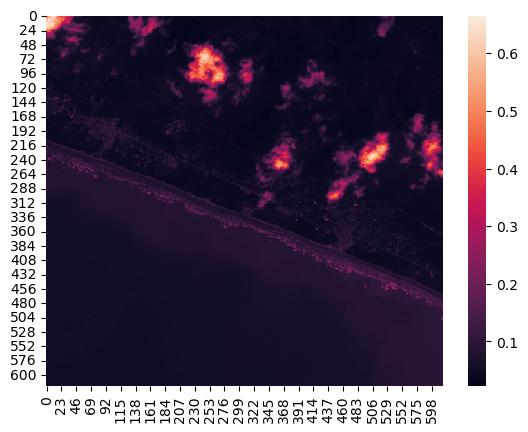

In [54]:
sns.heatmap(s2_processed[0, ..., 0]);

In [19]:
costa = pd.read_csv('../data/costarica.csv')
costa.tail(10)

,X,Y,Y_tile,X_tile,country
1447,-83.1389,8.3611,1114,484,Costa Rica
1448,-83.0833,8.3611,1114,485,Costa Rica
1449,-83.0278,8.3611,1114,486,Costa Rica
1450,-82.9722,8.3611,1114,487,Costa Rica
1451,-83.0833,8.3056,1113,485,Costa Rica
1452,-83.0278,8.3056,1113,486,Costa Rica
1453,-82.9722,8.3056,1113,487,Costa Rica
1454,-82.9722,8.2500,1112,487,Costa Rica
1455,-87.0833,5.5278,1063,413,Costa Rica
1456,-87.0278,5.5278,1063,414,Costa Rica


## Execute for Ashanti

In [4]:
ashanti.head()

,X,Y,Y_tile,X_tile,country,tile_idx
0,-1.4167,7.5833,1100,1660,Ghana,"(1660, 1100)"
1,-1.3611,7.5833,1100,1661,Ghana,"(1661, 1100)"
2,-1.4167,7.5278,1099,1660,Ghana,"(1660, 1099)"
3,-1.3611,7.5278,1099,1661,Ghana,"(1661, 1099)"
4,-1.0278,7.5278,1099,1667,Ghana,"(1667, 1099)"


In [26]:
# create a list of tiles - removing the missing one
ashanti_tiles = ashanti[['X_tile', 'Y_tile']].to_records(index=False)

(1660, 1100)
(1661, 1100)
(1660, 1099)
(1661, 1099)
(1667, 1099)
(1673, 1099)
(1658, 1098)
(1659, 1098)
(1660, 1098)
(1661, 1098)
(1662, 1098)
(1666, 1098)
(1667, 1098)
(1668, 1098)
(1669, 1098)
(1670, 1098)
(1671, 1098)
(1672, 1098)
(1673, 1098)
(1674, 1098)
(1648, 1097)
(1649, 1097)
(1650, 1097)
(1651, 1097)
(1652, 1097)
(1658, 1097)
(1659, 1097)
(1660, 1097)
(1661, 1097)
(1662, 1097)
(1663, 1097)
(1664, 1097)
(1665, 1097)
(1666, 1097)
(1667, 1097)
(1668, 1097)
(1669, 1097)
(1670, 1097)
(1671, 1097)
(1672, 1097)
(1673, 1097)
(1674, 1097)
(1647, 1096)
Raw data for (1647, 1096) does not exist.
(1648, 1096)
(1649, 1096)
(1650, 1096)
(1651, 1096)
(1652, 1096)
(1653, 1096)
(1657, 1096)
(1658, 1096)
(1659, 1096)
(1660, 1096)
(1661, 1096)
(1662, 1096)
(1663, 1096)
(1664, 1096)
(1665, 1096)
(1666, 1096)
(1667, 1096)
(1668, 1096)
(1669, 1096)
(1670, 1096)
(1671, 1096)
(1672, 1096)
(1673, 1096)
(1674, 1096)
(1675, 1096)
(1676, 1096)
(1650, 1095)
(1651, 1095)
(1652, 1095)
(1653, 1095)
(1654, 10

features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1661X1095Y_preds.tif
(1662, 1095)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 618, 612, 2)
Input array shape: (20, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
6882
0
Tile is 3.389068680330816% urban
False positive clouds [0.00482793 0.00484908 0.00450801 0.004664   0.00474332 0.0025541
 0.00513463 0.00487023 0.00378884 0.00080906 0.00267836 0.00014806
 0.00042039 0.00236108 0.0010999  0.0005288  0.00219716 0.00515578
 0.00513463 0.00513199]
Cloud/shadow percents [5.28798373e-05 3.55616887e-03 1.01523995e-01 7.80189112e-02
 2.36082032e-01 6.46191603e-03 2.10303105e-02 1.06349282e-01
 1.80875473e-02 2.22518351e-02 8.25078785e-01 4.24968787e-02
 1.64413989e-01 2.48498216e-01 1.48893759e-01 3

features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1668X1095Y_preds.tif
(1669, 1095)
The original max value is 52861
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
176
0
Tile is 5.893722105886583% urban
False positive clouds [0.00318337 0.00697485 0.00658354 0.00227912 0.00195127 0.00036751
 0.         0.00318865 0.00663906 0.0057877 ]
Cloud/shadow percents [0.0309347  0.14230493 0.1354517  0.18852983 0.13133764 0.0020253
 0.09756594 0.12331049 0.06551283 0.18616875]
False positive clouds [0.00953159 0.01035123 0.01006568 0.00936502 0.00808797 0.00582736
 0.00751951 0.00940203 0.01010534 0.01005774]
[0.08457072 0.2635108  0.29822641 0.49483628 0.28284895 0.00807739
 0.26633458 0.21851006 0.159

features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1677X1095Y_preds.tif
(1678, 1095)
The original max value is 48188
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
512
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [5.28798373e-05 4.04530758e-04 5.96870542e-01 3.63572657e-01
 1.92392707e-01 4.13792640e-01 6.24246476e-03 2.03666687e-02
 1.01894155e-01 5.84137082e-01]
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5.02358441e-04 1.26382808e-03 9.30663959e-01 5.69425937e-01
 3.49805402e-01 6.44187448e-01 1.83625230e-02 4.59340694e-02
 2.05668190e-01 8.30834761e-01]
features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free im

[5.02358441e-04 3.71227024e-01 1.32014510e-02 2.88797936e-01
 5.66152675e-01 3.44134040e-01 1.77998815e-01 6.56762273e-01
 1.08115468e-01 1.62975654e-01 5.13040168e-01 5.53680965e-01
 6.34243395e-01 3.31027772e-03 5.02358441e-04]
features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1655X1094Y_preds.tif
(1656, 1094)
The original max value is 65535
The original max value is 60508
Input array shape: (12, 618, 612, 2)
Input array shape: (16, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
3
0
Tile is 9.422129153711106% urban
False positive clouds [0.00828098 0.01389153 0.01337595 0.01465829 0.01333365 0.00973782
 0.00587759 0.00575068 0.00134844 0.00375447 0.00129291 0.00369101
 0.00230292 0.00914028 0.00923018 0.00853216]
Cloud/shadow percents [5.2879837e-05 4.5678130e-01 1.7529665e-03 1.12

[0.00212313 0.06766768 0.10988694 0.22594761 0.49194904 0.58063382
 0.17811515 0.00607325 0.1694455  0.81749318 0.2443683  0.52431679
 0.13887831 0.94373057 0.04823434 0.36942911 0.12443947 0.09910474
 0.00440225 0.00680299]
features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1661X1094Y_preds.tif
110/200 completed.
(1662, 1094)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 618, 612, 2)
Input array shape: (15, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
5348
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [5.28798373e-05 4.99714457e-04 1.01315118e-01 1.70426428e-01
 3.20819318e-01 1.44507378e-01 4.25116867e-01 1.05770245e-01
 2.84736753e-01 8.41741264e-02 5.14864512e-02 1.7637540

The original max value is 65535
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
69
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [0.03903589 0.0769666  0.20861624 0.09843846 0.06030152 0.00122681
 0.04015959 0.17896387 0.0053673  0.19615775]
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.10892189 0.18606828 0.45535884 0.29167724 0.15923441 0.00783415
 0.13386266 0.32425387 0.0152479  0.37370973]
features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1669X1094Y_preds.tif
(1670, 1094)
The original max value is 62298
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (

INTERPS MISSING
368
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [5.2879837e-05 3.7978299e-02 5.9058583e-01 1.0575968e-03 3.7211541e-02
 3.5669827e-01 1.2106839e-02 3.5897475e-02 2.8164330e-01 6.5640271e-01]
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5.02358441e-04 5.22796497e-02 8.58723587e-01 4.41546629e-03
 1.07459758e-01 5.74814392e-01 2.28202932e-02 7.14538782e-02
 4.51313535e-01 7.93067982e-01]
features: 13
sample shape: (618, 612, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1678X1094Y_preds.tif
(1679, 1094)
The original max value is 46818
The original max value is 46346
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
0
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 

Cloud/shadow percents [5.2707590e-05 1.5975671e-02 1.5206139e-03 5.4151777e-02 2.6383311e-01
 4.3278202e-02 4.7816062e-01 4.4353437e-03 1.1816778e-01 5.2496758e-03
 1.5859450e-01 3.5684884e-01 3.4356916e-01 1.5654154e-03 2.6037549e-03]
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5.00722094e-04 3.83368647e-02 5.34982027e-03 1.33690164e-01
 4.68581006e-01 9.15530818e-02 7.34704258e-01 1.48503632e-02
 2.80364842e-01 1.48477278e-02 3.36232251e-01 5.37591052e-01
 5.71492574e-01 5.34191413e-03 7.38169782e-03]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1656X1093Y_preds.tif
(1657, 1093)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 618, 614, 2)
Input array shape: (16, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
126

The original max value is 63189
Input array shape: (12, 618, 614, 2)
Input array shape: (17, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
0
0
Tile is 3.8798056144123634% urban
False positive clouds [0.00390563 0.00425087 0.00424296 0.00375014 0.00409011 0.00211885
 0.00159968 0.         0.         0.00073    0.         0.
 0.00110422 0.00183949 0.00435101 0.00294372 0.00355513]
Cloud/shadow percents [5.2707590e-05 3.6579065e-03 4.4008203e-02 1.1488146e-01 1.7225367e-01
 8.7050271e-01 3.0367741e-01 9.4900012e-02 3.4145030e-01 1.1234622e-02
 3.8798583e-01 1.3016139e-02 4.7840044e-02 1.9928738e-02 9.4343945e-02
 5.2707590e-05 2.0239714e-03]
False positive clouds [0.0048939  0.00498877 0.00500986 0.00626957 0.0064435  0.0063908
 0.0060113  0.00340227 0.00173144 0.00096718 0.00144682 0.0022717
 0.00435101 0.00467253 0.00498614 0.00472524 0.00463563]
[5.00722094e-04 9.04462224e-03 9.33108799e-02 2.78367224e-01
 3.44454635e-01 9.65813858e-01 5.46849140e-01 1.91752844e-01
 5.4835

The original max value is 65535
Input array shape: (12, 618, 614, 2)
Input array shape: (17, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
96
0
Tile is 5.2586361384312115% urban
False positive clouds [0.00663589 0.00681509 0.00686253 0.00581101 0.00686253 0.00686253
 0.00664643 0.00686253 0.00457238 0.00262747 0.00553693 0.00477267
 0.00261693 0.00277242 0.00673076 0.00686253 0.00673603]
Cloud/shadow percents [5.27075899e-05 2.47462140e-03 6.72285305e-03 1.24231786e-01
 1.45219952e-01 3.25980633e-01 8.22949931e-02 7.16454238e-02
 6.50011063e-01 8.05951729e-02 3.12521756e-01 3.64104025e-02
 4.70705107e-02 1.35732576e-01 5.27075899e-05 8.43216032e-02
 1.73671506e-02]
False positive clouds [0.00804054 0.00809589 0.00811697 0.00796939 0.00811697 0.00811697
 0.00805372 0.00811697 0.00796148 0.0077322  0.00788242 0.00791141
 0.00747657 0.00760043 0.00808271 0.00811697 0.0081117 ]
[5.00722094e-04 9.86686063e-03 2.38897146e-02 2.53336390e-01
 2.82905348e-01 5.20023613e-01 1.640813

[5.00722094e-04 3.79758178e-03 3.11288384e-01 2.27791657e-01
 7.06305409e-01 2.33175738e-01 5.00722094e-04 2.13254904e-01
 3.55644456e-01 4.37736525e-02]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1676X1093Y_preds.tif
(1677, 1093)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
418
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [5.2707590e-05 1.3054879e-01 1.8706186e-01 9.3084238e-02 3.0741173e-01
 1.6233674e-01 5.4025277e-03 1.3292064e-01 3.3461675e-01 5.2707590e-05]
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[5.00722094e-04 1.79648546e-01 4.11501323e-01 2.33186279e-01
 5.07302636e-01 2.8503737

[0.0144287  0.2479813  0.62827446 0.48163931 0.22058389 0.20442111
 0.5117169  0.04948716]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1655X1092Y_preds.tif
(1656, 1092)
The original max value is 49164
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (8, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
0
541
Tile is 18.071060371272253% urban
False positive clouds [0.04526528 0.04905495 0.02464343 0.00723939 0.01085776 0.01179859
 0.02408737 0.0357173 ]
Cloud/shadow percents [5.4288819e-04 5.2480947e-02 1.3457565e-01 2.6959932e-01 1.0277980e-02
 4.8686001e-02 3.2088116e-01 5.2707590e-05]
False positive clouds [0.05695582 0.05765156 0.05582524 0.05133456 0.03324268 0.04360235
 0.04568694 0.0466673 ]
[3.29949506e-03 8.27535499e-02 2.74332458e-01

[5.00722094e-04 2.47699314e-02 9.91113501e-02 4.24570170e-01
 3.93773125e-01 4.92067508e-01 2.41153031e-01 5.68127194e-01
 1.10736009e-01 4.12226052e-02 3.74208068e-01 4.85674077e-02
 2.53526138e-01 3.57420701e-01 9.56352846e-02 6.23201354e-01
 6.79137282e-03 1.34731139e-01]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1662X1092Y_preds.tif
170/200 completed.
(1663, 1092)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 618, 614, 2)
Input array shape: (18, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
4403
0
Tile is 4.499910397098975% urban
False positive clouds [0.00732635 0.00700747 0.00612199 0.00569505 0.00741859 0.00229805
 0.00527076 0.00282776 0.00176834 0.00331267 0.00100408 0.00198181
 0.00241137 0.00299643 0.00331267 0.00621159 0.

[5.56855676e-03 1.18004385e-01 2.48621697e-02 2.34293139e-01
 2.93539104e-01 4.99852419e-01 5.46156036e-02 9.61043821e-02
 8.02343906e-01 5.93302974e-02 3.32537449e-01 8.01347733e-01
 2.63883179e-01 1.66753634e-01 3.91182547e-01 7.86687117e-02
 3.49177235e-01 5.00722094e-04 8.89150670e-02 3.49714852e-02]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1668X1092Y_preds.tif
(1669, 1092)
The original max value is 65535
The original max value is 65535
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
3005
0
Tile is 15.933240567976977% urban
False positive clouds [0.00763997 0.01673993 0.01046509 0.00697321 0.00094874 0.00271181
 0.00271708 0.00374487 0.00535773 0.00524968]
Cloud/shadow percents [3.24915946e-02 1.07613087e-01 3.2

Cloud/shadow percents [0.00775592 0.01319007 0.5641372  0.17898443 0.4659298  0.276475
 0.00988794 0.12489854 0.17054331 0.1840997 ]
False positive clouds [0.00858607 0.00875737 0.00865986 0.0082013  0.00711025 0.00359466
 0.00499404 0.00604029 0.00671231 0.00660426]
[0.02624311 0.03166408 0.81644846 0.37898074 0.69524999 0.54282755
 0.02659098 0.24926473 0.30871625 0.32037517]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/1676X1092Y_preds.tif
(1677, 1092)
The original max value is 54866
The original max value is 57710
Input array shape: (12, 616, 612, 2)
Input array shape: (10, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
0
0
Tile is 0.0% urban
False positive clouds [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Cloud/shadow percents [0.0206561  0.01298188 0.4383242  0.07149521 0.26423633 0.

Baseline: 0.609
Writing ../tmp/ashanti/preds/1654X1091Y_preds.tif
(1655, 1091)
The original max value is 51805
The original max value is 53273
Input array shape: (12, 616, 612, 2)
Input array shape: (8, 618, 613, 4)
Input array shape: (618, 613)
INTERPS MISSING
0
728
Tile is 18.995287941557827% urban
False positive clouds [0.02905242 0.03517704 0.02781116 0.01693231 0.0126182  0.01592296
 0.02239282 0.02988257]
Cloud/shadow percents [5.2707590e-05 4.7858492e-02 1.5708180e-01 1.3623330e-01 1.3095200e-01
 1.4788958e-01 1.2550731e-01 1.6547548e-02]
False positive clouds [0.04038983 0.04192098 0.04014474 0.03733542 0.02989838 0.03165618
 0.03375394 0.03544058]
[0.00050072 0.09533749 0.30131347 0.36984388 0.26097108 0.36565626
 0.34089687 0.0493264 ]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Baseline: 0.609
Writing ../tmp/ashanti/preds/

Cloud/shadow percents [3.36801494e-03 5.27075899e-05 3.64209432e-03 9.04409513e-02
 1.22887745e-01 2.88046966e-03 4.61033285e-02 2.46160254e-01
 2.41664285e-03 4.57132906e-02 1.30203560e-01 2.09091008e-02
 1.65536091e-01 3.68916214e-01 1.05291314e-01 3.53349030e-01
 5.18379128e-03 2.87730731e-02]
False positive clouds [0.04843827 0.05179311 0.05360362 0.05522174 0.05505044 0.05370113
 0.0496769  0.04127268 0.02740795 0.02067192 0.02147834 0.03114491
 0.04002087 0.04562369 0.04921044 0.05203557 0.05137936 0.05119225]
[1.42811212e-02 5.00722094e-04 1.34457059e-02 1.79896271e-01
 2.54055849e-01 1.16720955e-02 1.02861495e-01 5.37667478e-01
 9.72982090e-03 9.47603386e-02 2.56480398e-01 8.42978822e-02
 3.45801313e-01 5.55198022e-01 2.22136133e-01 6.01962831e-01
 2.11225662e-02 8.53968354e-02]
features: 13
sample shape: (618, 614, 13)
Plot id 8023 has no cloud free imagery and will be removed.
Plot id 8124 has no cloud free imagery and will be removed.
Training data includes 218 plot ids.
Bas

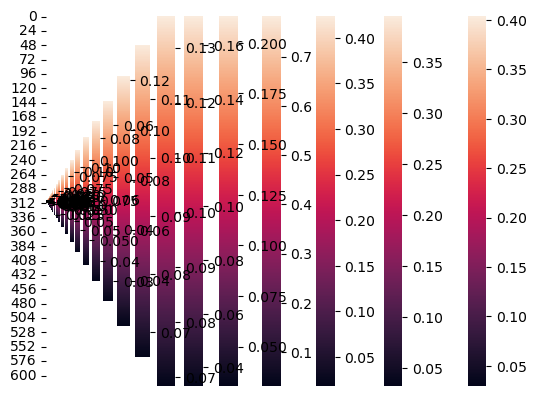

In [31]:
# run predictions on all the tiles
counter = 0

for tile in ashanti_tiles[:200]:
    counter += 1
    print(tile)
    if os.path.exists(f'../tmp/ashanti/preds/{str(tile[0])}X{str(tile[1])}Y_preds.tif'):
        continue
    else:
        p.execute(tile, 'ashanti', 'cat_model_v8_nf')
        if counter % 5 == 0:
            print(f'{counter}/200 completed.')

In [36]:
m.mosaic_tif('ashanti', 'cat_model_v8_nf')

Merging 199 tifs...


## Mosaic Error

In [73]:
filename = 'test_merge'
gdal.BuildVRT(f'../tmp/preds/{str(filename)}.vrt', tifs_to_mosaic, options=gdal.BuildVRTOptions(srcNodata=255, VRTNodata=255))
#translateoptions = gdal.TranslateOptions(gdal.ParseCommandLine("-ot Byte -co COMPRESS=LZW -a_nodata 255 -co BIGTIFF=YES"))
translateoptions = gdal.TranslateOptions(format='Gtiff', 
                                          outputSRS='EPSG:4326',
                                          outputType=gdal.GDT_Byte,
                                          noData=255,
                                          creationOptions=['COMPRESS=LZW', 'BIGTIFF=YES'])
                                         

ds = gdal.Open(f'../tmp/preds/{str(filename)}.vrt')
ds = gdal.Translate(f'../tmp/preds/{str(filename)}.tif', ds, options=translateoptions)



Warning 1: Can't open 1677X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1678X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1674X1085Y_preds.tif. Skipping it
Warning 1: Can't open 1680X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1676X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1679X1162Y_preds.tif. Skipping it
Warning 1: Can't open 1660X1161Y_preds.tif. Skipping it
Warning 1: Can't open 1678X1163Y_preds.tif. Skipping it
Warning 1: Can't open 1666X1161Y_preds.tif. Skipping it
Warning 1: Can't open 1679X1163Y_preds.tif. Skipping it
ERROR 4: ../tmp/preds/test_merge.vrt: No such file or directory


ValueError: Received a NULL pointer.